# Elliptic++ Upgrade Model 

In [ ]:
!pip install torch
!pip install torch_geometric
!pip install faiss-cpu

## Data processing

In [2]:
import pandas as pd
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
import faiss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt


# Load the dataset
df_txs_features = pd.read_csv('../data/txs_features.csv')
df_txs_classes = pd.read_csv('../data/txs_classes.csv')
df_txs_edgelist = pd.read_csv('../data/txs_edgelist.csv')

# Clean features by dropping NaN values and reset the index
df_txs_features_clean = df_txs_features.dropna().reset_index(drop=True)

# Standardize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(df_txs_features_clean.drop(columns=['txId']))
features_clean = torch.tensor(normalized_features, dtype=torch.float32)

# Get the valid transaction IDs after cleaning
valid_transaction_ids = df_txs_features_clean['txId']

# Filter labels based on valid transaction IDs
labels_clean = df_txs_classes[df_txs_classes['txId'].isin(valid_transaction_ids)].reset_index(drop=True)

# Adjust labels to be zero-based
labels_clean = torch.tensor(labels_clean['class'].values - 1, dtype=torch.long)

# Filter edges based on valid transaction IDs
filtered_edges = df_txs_edgelist[
    (df_txs_edgelist['txId1'].isin(valid_transaction_ids)) & (df_txs_edgelist['txId2'].isin(valid_transaction_ids))
].reset_index(drop=True)

# Create edge_index tensor from filtered edges
edge_index_df = filtered_edges[['txId1', 'txId2']]

# Create a mapping from transaction IDs to indices
id_to_index = {txId: index for index, txId in enumerate(valid_transaction_ids)}

# Map the edges to the new indices using the DataFrame values
edge_index = torch.tensor([[id_to_index[txId] for txId in edge_index_df['txId1']],
                            [id_to_index[txId] for txId in edge_index_df['txId2']]], dtype=torch.long)


In [33]:
# setting seeds
seed = 42 
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark=False

## GCN and ANN Model

In [34]:
# Function to get ANN neighbors with specified k
def get_ann_neighbors(features, k):
    index = faiss.IndexFlatL2(features.shape[1])
    index.add(features.numpy())
    _, indices = index.search(features.numpy(), k)
    ann_edges = []
    for i, neighbors in enumerate(indices):
        for j in neighbors:
            if i != j:  # Avoid self-loops
                ann_edges.append([i, j])
    ann_edge_index = torch.tensor(ann_edges, dtype=torch.long).t().contiguous()
    return ann_edge_index

# Hybrid GNN Model
class HybridGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(HybridGNN, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gat1 = GATConv(hidden_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, ann_edge_index):
        x = self.gcn1(x, torch.cat([edge_index, ann_edge_index], dim=1))
        x = F.relu(x)
        x = self.gat1(x, torch.cat([edge_index, ann_edge_index], dim=1))
        x = F.relu(x)
        x = self.gcn2(x, edge_index)
        return x

# Initialize train-test split
train_mask, test_mask = train_test_split(range(len(labels_clean)), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

    
model = HybridGNN(in_channels=features_clean.size(1), hidden_channels=64, out_channels=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, threshold=1e-4, min_lr=5e-6)
    



In [35]:
# Function to train and evaluate the model
def train_and_evaluate(k):
    ann_edge_index = get_ann_neighbors(features_clean, k)

    # Training and evaluation loop
    num_epochs = 200
    loss_history = []
    accuracy_history = []

    for epoch in range(1, num_epochs + 1):
        # Training step
        model.train()
        optimizer.zero_grad()
        out = model(features_clean, edge_index, ann_edge_index)
        loss = criterion(out[train_mask], labels_clean[train_mask])
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        
        # Testing step every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                out = model(features_clean, edge_index, ann_edge_index)
                pred = out.argmax(dim=1)
                correct = (pred[test_mask] == labels_clean[test_mask]).sum()
                test_acc = int(correct) / len(test_mask)
                accuracy_history.append(test_acc)
                
            avg_loss = sum(loss_history[-10:]) / len(loss_history[-10:])  # Average loss for last 10 epochs
            print(f'k={k}, Epoch: {epoch}, Avg Loss (last 10): {avg_loss:.4f}, Test Accuracy: {test_acc:.4f}')
            
            # Adjust learning rate
            scheduler.step(avg_loss)
            print(f'lr: {scheduler.get_last_lr()}')
    
    final_test_acc = test_acc
    print(f'Final Test Accuracy with k={k} after {num_epochs} epochs: {final_test_acc:.4f}')
    
    return loss_history, accuracy_history, final_test_acc

In [ ]:
# Testing different values of k
k_values = [5, 10, 15, 20]  
results = {}

# Collect results for all k values
for k in k_values:
    print(f"\nTesting with k={k}")
    loss_history, accuracy_history, final_test_acc = train_and_evaluate(k)
    results[k] = {
        'loss_history': loss_history,
        'accuracy_history': accuracy_history,
        'final_test_acc': final_test_acc
    }

# Print the final test accuracy for each k
print("\nResults for different values of k:")
for k, result in results.items():
    print(f"k={k}: Final Test Accuracy = {result['final_test_acc']:.4f}")

## Results

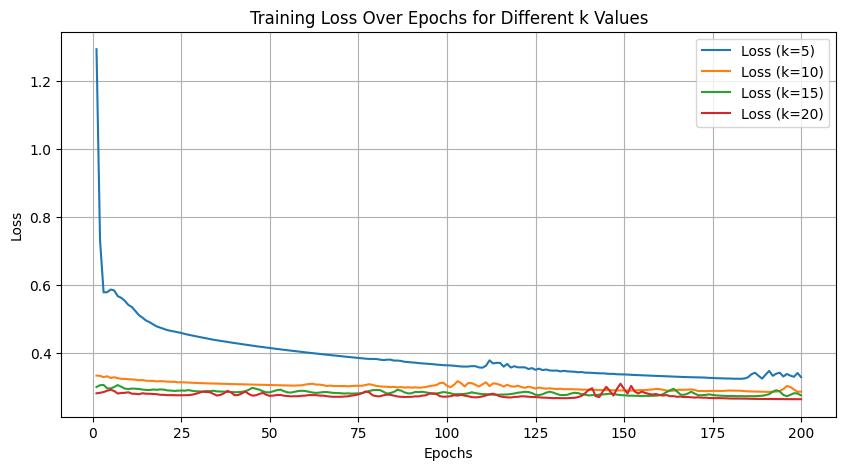

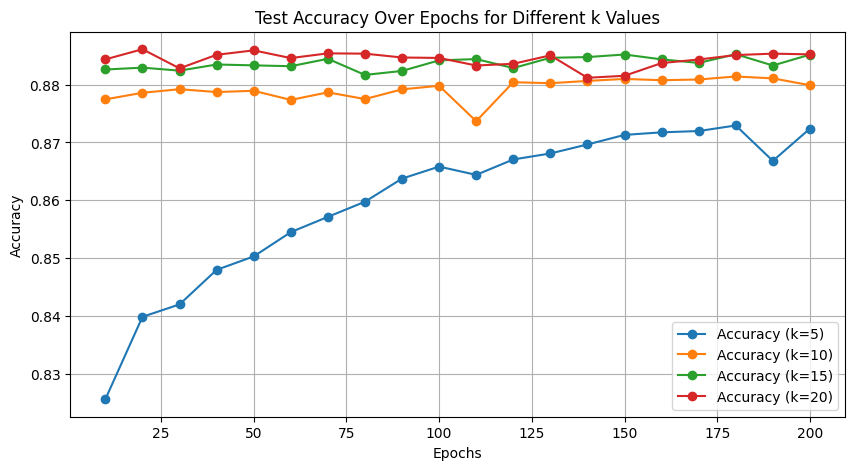

In [40]:
# After all evaluations, plot the results
plt.figure(figsize=(10, 5))
for k in k_values:
    plt.plot(range(1, 201), results[k]['loss_history'], label=f'Loss (k={k})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs for Different k Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
for k in k_values:
    plt.plot(range(10, 201, 10), results[k]['accuracy_history'], marker='o', label=f'Accuracy (k={k})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs for Different k Values')
plt.legend()
plt.grid(True)
plt.show()